<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Notebook 3: Assessing Module Fairness

In 2016 researchers built an AI to distinguish melanoma from clinical images. The algorithm was trained on over 100,000 images. The photographs were labeled either "malignant" or "benign." The algorithm correctly identified 95% of the melanomas, but scientest Stephanie Dutchen pointed out that [95% of the images used for training were light skinned](https://blog.petrieflom.law.harvard.edu/2019/10/29/).

In the previous module, we classified skin lession photos using several different Machine Learning algorithms.

How would these algorithms work in a broader context, deployed for people around the world? Would the model still perform well?

In today's module, we will determine whether or not our trained model is classifying fairly. We will:
*   Retrain our best model from the previous notebook
*   Classify images' skin tones based on RGB values
*   Compare our model's accuracy across different skin tones


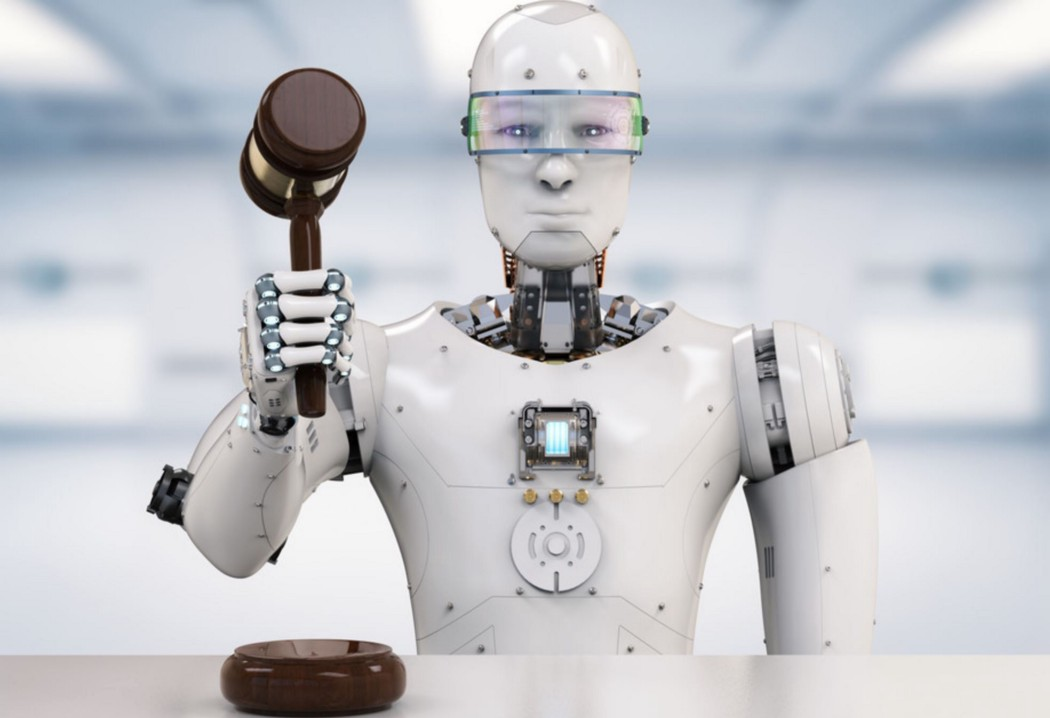

# What is Algorithmic Fairness?

**Question:** How would you determine if an algorithm is fair?

Here's a definition from [Wikipedia](https://en.wikipedia.org/wiki/Fairness_(machine_learning):
*An algorithm is said to be fair... if its results are independent of given variables, especially those considered sensitive, such as the traits of individuals which should not correlate with the outcome (i.e. gender, ethnicity, sexual orientation, disability, etc).*

Algorithmic fairness is particularly important in instances where there can be potential harms of an unaccurate prediction. In the case of skin cancer diagnosis, there are assorted risks with producing false positives and false negatives.

**Discuss:** Which of the traits listed traits do you think would be most relevent with skin lession photos? Why does fairness matter for this problem?



# Setup our Environment

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

print("Downloading data...")

!wget https://www.dropbox.com/s/fedqcdt4o0m2oxp/X.npy &> /dev/null
!wget https://www.dropbox.com/s/h7xh92w1w7px30a/X_g.npy &> /dev/null
!wget https://www.dropbox.com/s/grn9brfvzx74c8a/y.npy &> /dev/null

print("Importing stuff...")

import os
import random
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.mobilenet import MobileNet
from keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Prepare data

os.makedirs("static/js", exist_ok=True)
!wget -O static/js/skin_cancer_diagnosis_script.js 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/skin_cancer_diagnosis_script.js' &> /dev/null
output = 'static/js/skin_cancer_diagnosis_script.js'

print("Done")

Importing stuff...
Done


Let's load in our data from last time!

In [ ]:
IMG_WIDTH = 100
IMG_HEIGHT = 75
X = np.load("X.npy")
X_g = np.load("X_g.npy")
y = np.load("y.npy")

# Re-implementing the Most Effective Model
Now, let's re-train the transfer learning model we built in Notebook 2. We'll examine its effectiveness for different skin tones.

In [ ]:
#@title Run this to Perform Data Augmentation! { display-mode: "form" }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
X_g_train, X_g_test, y_train, y_test = train_test_split(X_g, y, test_size=0.4, random_state=101)

X_augmented = []
X_g_augmented = []

y_augmented = []

for i in range(len(X_train)):
  transform = random.randint(0,1)
  if (transform == 0):
    # Flip the image across the y-axis
    X_augmented.append(cv2.flip(X_train[i],1))
    X_g_augmented.append(cv2.flip(X_g_train[i],1))
    y_augmented.append(y_train[i])
  else:
    # Zoom 33% into the image
    zoom = 0.33

    centerX,centerY=int(IMG_HEIGHT/2),int(IMG_WIDTH/2)
    radiusX,radiusY= int((1-zoom)*IMG_HEIGHT*2),int((1-zoom)*IMG_WIDTH*2)

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    cropped = (X_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_augmented.append(new_img)

    cropped = (X_g_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_g_augmented.append(new_img)

    y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
X_g_augmented = np.array(X_g_augmented)

y_augmented = np.array(y_augmented)

X_train = np.vstack((X_train,X_augmented))
X_g_train = np.vstack((X_g_train,X_g_augmented))

y_train = np.append(y_train,y_augmented)

In [ ]:
#@title Run this to Define our Transfer Learning CNN Model! { display-mode: "form" }
def transfer_learning_model():
  mobilenet_model = MobileNet(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, pooling="max")

  transfer_model = Sequential()
  transfer_model.add(mobilenet_model)
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(256, activation="relu"))
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(7, activation="softmax"))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  transfer_model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[AUC()])

  return transfer_model

In [ ]:
#@title Transform our labels into One Hot encodings! { display-mode: "form" }
y_train_roc = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_roc[np.arange(y_train.size),y_train.astype(int)] = 1

y_test_roc = np.zeros((y_test.size, y_test.max().astype(int)+1))
y_test_roc[np.arange(y_test.size),y_test.astype(int)] = 1

**Exercise:** Set up and train the transfer model.

In [ ]:
#Your Code Here
transfer_model = KerasClassifier(build_fn=transfer_learning_model, verbose=1,epochs=5)
#train the model
transfer_model.fit(X_train.astype(np.float32), y_train_roc.astype(np.float32), validation_data=(X_test.astype(np.float32),y_test_roc.astype(np.float32)), verbose=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/5
37/37 [==============================] - 20s 70ms/step - loss: 1.9132 - auc: 0.7112 - val_loss: 2.9884 - val_auc: 0.5923
Epoch 2/5
37/37 [==============================] - 1s 36ms/step - loss: 0.9918 - auc: 0.9176 - val_loss: 2.4082 - val_auc: 0.6840
Epoch 3/5
37/37 [==============================] - 1s 37ms/step - loss: 0.6462 - auc: 0.9660 - val_loss: 1.7686 - val_auc: 0.7822
Epoch 4/5
37/37 [==============================] - 1s 37ms/step - loss: 0.4235 - auc: 0.9877 - val_loss: 1.5383 - val_auc: 0.8343
Epoch 5/5
37/37 [==============================] - 1s 38ms/step - loss: 0.3215 - auc: 0.9928 - val_loss: 1.4020 - val_auc: 0.8608


In [ ]:
#@title Run this to redefine `plot_cm()`! { display-mode: "form" }
def plot_cm(name, y_test_class, y_pred_class):
  cm = confusion_matrix(y_test_class, y_pred_class)
  classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

  classes_present = []
  for i in range(len(classes)):
    if i in y_pred_class or i in y_test_class:
      classes_present.append(classes[i])

  df_cm = pd.DataFrame(cm, index = [i for i in classes_present], columns = [i for i in classes_present])
  df_cm = df_cm.round(5)

  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(name + " Model Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

For simplicity, we'll use accuracy as a metric in this notebook. Later on, we'll compare the accuracy of our model for each of our skin tone classes. For now, output the confusion matrix and the overall accuracy of our model for the entire test set:

In [ ]:
# Your Code Here

#Classifying Skin Tones

Now, we'll see how well our model performs for images of different skin tones.

We will classify each image in our test set based on a skin tone palette, shown below. We will use the average RGB pixel values to determine which skin tone each photo is closest to.

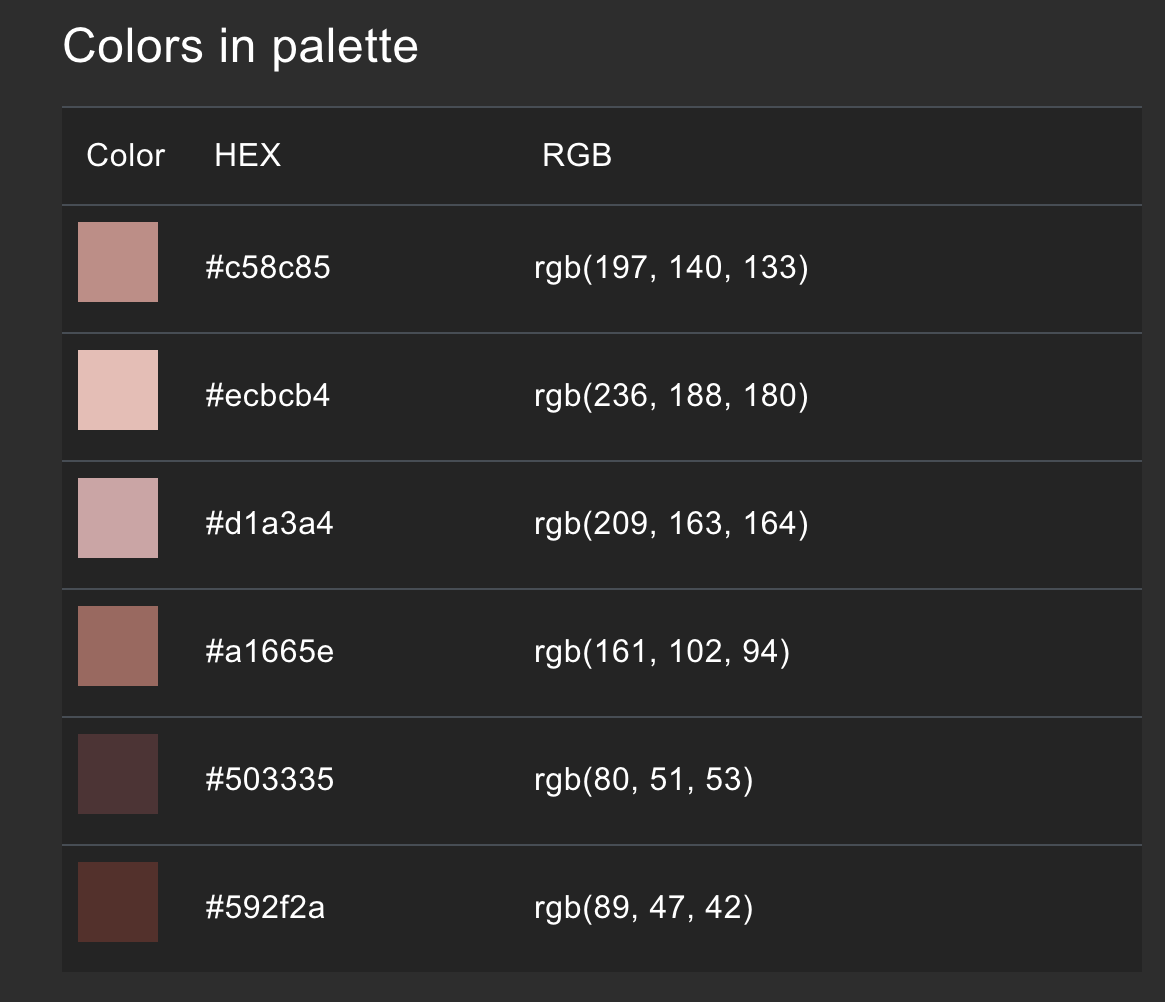

Run the following code to find the average red, green, and blue values of each image in the test set.

In [ ]:
# images of size 75x100 with 3 output rgb channels
avg_rgb = X_test.mean(axis=2).mean(axis=1)
print(avg_rgb.shape)

(387, 3)


Now we have found the average red, green, and blue values for each image. We will use a clustering approach to find which of the six skin tones each image vector is closest to. We will use Euclidean Distance as our metric of similarity.

We define the function closest_node(node,nodes) which takes in the average RGB values of a photo, and finds the closest skin color out of the nodes.

In [ ]:
nodes = [[197, 140, 133], [236, 188, 180], [209, 163, 164], [161, 102, 94], [80, 51, 53], [89, 47, 42]]

# finds the closest color from the nodes array by index.
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

You can try it out with a particular image:

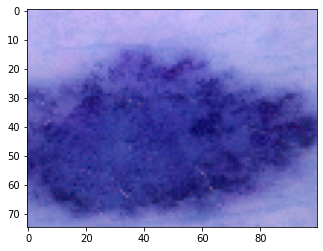

Skin tone class: 3


In [ ]:
img_num = 4 #Choose any image here
img = X_test[img_num]
plt.imshow(img)
plt.show()
print ("Skin tone class:", closest_node(avg_rgb[img_num], nodes))

**Excercise:** Iterate through `avg_rgb`, use `closest_node` to find the skin class for each image, and append the results to a `skin_classes` list.





In [ ]:
#Your Code Here
skin_classes = []
for i in avg_rgb:
  skin_classes.append(closest_node(avg_rgb[i], nodes))


AttributeError: ignored

We will visualize the results of our findings using a bar chart.

In [ ]:
#@title Run to plot skin class frequency in the test set!

frequency = []
for i in range(6):
  frequency.append(skin_classes.count(i))

plt.bar([0,1,2,3,4,5], frequency, label="skin class frequencies")

# The following commands add labels to our figure.
plt.xlabel('Skin Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Skin Classes')

NameError: ignored

**Discuss:** What can we infer about our dataset based on the barchart? What could explain these patterns? How do you think this will impact the results of the model on each of these categories?  


#Measuring Fairness by Skin Tone
Now that we have the overall accuracy of our model, let's break it down further by skin tone classes within the test set. The code below will select the portions of `y_test` and `y_pred` for each class; complete it to show the accuracy and confusion matrix for each class.

In [ ]:
for skin_class in range(6):
  print ("Skin Class: {}".format(skin_class))
  mask = (np.array(skin_classes) == skin_class)
  y_test_class = y_test[mask]
  y_pred_class = y_pred[mask]
  print ("Number of images: {}".format(len(y_test_class)))
  #YOUR CODE HERE to output accuracy and confusion matrix per class

Skin Class: 0


NameError: ignored

**Discuss:**

*  What did you observe from the confusion matrices for the different skin type classifications?
* Do you think the algorithm is fair? Why or why not?
* What are some potential confounding variables to our transfer learning model that may have impacted how the model was trained?

# Conclusion/Consequences

The rates of skin cancer has been on a 30-year climb. There are a lot of benefits of using Machine learning to diagnose Melanoma, such as being able to reach a much larger audience, especially where resources would otherwise be lacking.

German researchers even found that convolutional neural networks detected potentially cancerous skin lesions better than the 58 dermatologists included in the study group([Oncol 2018 ](https://pubmed.ncbi.nlm.nih.gov/29846502/))

However, if the dataset used contains bias, the results of using such technology could be potentially dangerous.


**Discuss :** What are some other potential consequences of using data that is not demographically representative? What are some solutions to creating less bias models?

If the algorithm is not trained on a diverse set of images, then the algorithm when applied to real people also won't work well on a diverse audience.

The risk of misdiagnosis is intensified by the statistics that while fair-skinned people are at the highest risk for contracting skin cancer, the mortality rate for African Americans is considerably higher.  Their five-year survival rate is 73 percent, compared with 90 percent for white Americans, according to the American Academy of Dermatology ([Lashbrook](https://www.theatlantic.com/health/archive/2018/08/machine-learning-dermatology-skin-color/567619/)).
